This notebook allows collecting results across multiple pipeline runs. Concatenating across sessions and bin sizes. 
It takes CSVs, then determines the most recent one from the filename. 

There are two major sets of decoded epochs - Laps and Ripples/Replays
There are two sets of marginals for the decoded epochs - the "by epoch" and "by time bin" marginals.
The "by time bin" epochs are a larger granulation, with each epoch consisting of one or more time bin.


```python

# 2024-01-23 - 
# C:/Users/pho/repos/Spike3DWorkEnv/Spike3D/output/collected_outputs/2024-01-23_GL-fet11-01_12-58-54_time_bin_size_sweep_results.h5
# C:/Users/pho/repos/Spike3DWorkEnv/Spike3D/output/collected_outputs/2024-01-23_GL-11-03_12-3-25_time_bin_size_sweep_results.h5
# C:/Users/pho/repos/Spike3DWorkEnv/Spike3D/output/collected_outputs/2024-01-23_GL-11-02_17-46-44_time_bin_size_sweep_results.h5
# C:/Users/pho/repos/Spike3DWorkEnv/Spike3D/output/collected_outputs/2024-01-23_GL-11-02_19-28-0_time_bin_size_sweep_results.h5
# C:/Users/pho/repos/Spike3DWorkEnv/Spike3D/output/collected_outputs/2024-01-23_GL-2006-4-10_12-58-3_time_bin_size_sweep_results.h5
# C:/Users/pho/repos/Spike3DWorkEnv/Spike3D/output/collected_outputs/2024-01-23_GL-2006-4-10_12-25-50_time_bin_size_sweep_results.h5
# C:/Users/pho/repos/Spike3DWorkEnv/Spike3D/output/collected_outputs/2024-01-23_GL-2006-4-09_16-40-54_time_bin_size_sweep_results.h5
# C:/Users/pho/repos/Spike3DWorkEnv/Spike3D/output/collected_outputs/2024-01-23_GL-2006-6-09_22-24-40_time_bin_size_sweep_results.h5
# C:/Users/pho/repos/Spike3DWorkEnv/Spike3D/output/collected_outputs/2024-01-23_GL-2006-6-12_16-53-46_time_bin_size_sweep_results.h5
# C:/Users/pho/repos/Spike3DWorkEnv/Spike3D/output/collected_outputs/2024-01-23_GL-2006-4-09_17-29-30_time_bin_size_sweep_results.h5
# C:/Users/pho/repos/Spike3DWorkEnv/Spike3D/output/collected_outputs/2024-01-23_GL-2006-6-08_14-26-15_time_bin_size_sweep_results.h5
# C:/Users/pho/repos/Spike3DWorkEnv/Spike3D/output/collected_outputs/2024-01-23_GL-2006-6-09_1-22-43_time_bin_size_sweep_results.h5
# C:/Users/pho/repos/Spike3DWorkEnv/Spike3D/output/collected_outputs/2024-01-23_GL-2006-6-07_16-40-19_time_bin_size_sweep_results.h5
# C:/Users/pho/repos/Spike3DWorkEnv/Spike3D/output/collected_outputs/2024-01-23_GL-2006-6-08_21-16-25_time_bin_size_sweep_results.h5
# C:/Users/pho/repos/Spike3DWorkEnv/Spike3D/output/collected_outputs/2024-01-23_GL-2006-6-12_15-55-31_time_bin_size_sweep_results.h5



# found_session_export_paths = [Path(v).resolve() for v in  ["C:/Users/pho/repos/Spike3DWorkEnv/Spike3D/output/collected_outputs/2024-01-12_0420PM-kdiba_pin01_one_fet11-01_12-58-54-(laps_marginals_df).csv",
# "C:/Users/pho/repos/Spike3DWorkEnv/Spike3D/output/collected_outputs/2024-01-12_0420PM-kdiba_pin01_one_fet11-01_12-58-54-(ripple_marginals_df).csv",
# "C:/Users/pho/repos/Spike3DWorkEnv/Spike3D/output/collected_outputs/2024-01-12_0645PM-kdiba_pin01_one_fet11-01_12-58-54-(laps_marginals_df).csv",
# "C:/Users/pho/repos/Spike3DWorkEnv/Spike3D/output/collected_outputs/2024-01-12_0645PM-kdiba_pin01_one_fet11-01_12-58-54-(ripple_marginals_df).csv",
# "C:/Users/pho/repos/Spike3DWorkEnv/Spike3D/output/collected_outputs/2024-01-12_0828PM-kdiba_pin01_one_fet11-01_12-58-54-(laps_marginals_df).csv",
# "C:/Users/pho/repos/Spike3DWorkEnv/Spike3D/output/collected_outputs/2024-01-12_0828PM-kdiba_pin01_one_fet11-01_12-58-54-(ripple_marginals_df).csv",
# ]]
```

In [1]:
%config IPCompleter.use_jedi = False
%pdb off
%load_ext autoreload
%autoreload 3

# required to enable non-blocking interaction:
%gui qt5

import sys
from copy import deepcopy
from typing import List, Dict, Tuple, Optional, Union, Callable
import numpy as np
import pandas as pd
import re
from pathlib import Path
from datetime import datetime
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Plotting
# import pylustrator # customization of figures
import matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt
_bak_rcParams = mpl.rcParams.copy()

# matplotlib.use('Qt5Agg')
# %matplotlib inline
%matplotlib auto

# _restore_previous_matplotlib_settings_callback = matplotlib_configuration_update(is_interactive=True, backend='Qt5Agg')
# _restore_previous_matplotlib_settings_callback = matplotlib_configuration_update(is_interactive=True, backend='Qt5Agg')
import seaborn as sns

# from ..PendingNotebookCode import plot_across_sessions_scatter_results, plot_histograms, plot_stacked_histograms
from pyphocorehelpers.Filesystem.path_helpers import find_first_extant_path
from pyphoplacecellanalysis.SpecificResults.PendingNotebookCode import find_csv_files, find_HDF5_files, find_most_recent_files, process_csv_file
from pyphoplacecellanalysis.SpecificResults.PendingNotebookCode import plot_across_sessions_scatter_results, plot_histograms, plot_stacked_histograms

debug_print: bool = False

Automatic pdb calling has been turned OFF
Using matplotlib backend: <object object at 0x7f8a363c5590>


/home/halechr/repos/Spike3D/.venv/lib/python3.9/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.3, the latest is 0.5.4.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


# Definitions

In [2]:
## Load across session t_delta CSV, which contains the t_delta for each session:


# t_delta_csv_path = Path(r'C:\Users\pho\repos\Spike3DWorkEnv\Spike3D\output\collected_outputs\2024-01-18_GL_t_split_df.csv').resolve() # Apogee
# t_delta_csv_path = Path('/home/halechr/cloud/turbo/Data/Output/collected_outputs/2024-01-18_GL_t_split_df.csv').resolve() # GL

# collected_outputs_directory = '/home/halechr/FastData/collected_outputs/'
# collected_outputs_directory = r'C:\Users\pho\Desktop\collected_outputs'
# collected_outputs_directory = r'C:/Users/pho/repos/Spike3DWorkEnv/Spike3D/output/collected_outputs' # APOGEE
# collected_outputs_directory = '/home/halechr/cloud/turbo/Data/Output/collected_outputs' # GL


known_collected_outputs_paths = [Path(v).resolve() for v in [r'C:/Users/pho/repos/Spike3DWorkEnv/Spike3D/output/collected_outputs', '/home/halechr/cloud/turbo/Data/Output/collected_outputs', '/home/halechr/FastData/collected_outputs/']]
collected_outputs_directory = find_first_extant_path(known_collected_outputs_paths)
assert collected_outputs_directory.exists(), f"collected_outputs_directory: {collected_outputs_directory} does not exist! Is the right computer's config commented out above?"
# fullwidth_path_widget(scripts_output_path, file_name_label='Scripts Output Path:')
print(f'collected_outputs_directory: {collected_outputs_directory}')

t_delta_csv_path = collected_outputs_directory.joinpath('2024-01-18_GL_t_split_df.csv').resolve() # GL
assert t_delta_csv_path.exists()

## Find the files:
csv_files = find_csv_files(collected_outputs_directory)
h5_files = find_HDF5_files(collected_outputs_directory)

csv_sessions = find_most_recent_files(found_session_export_paths=csv_files)
h5_sessions = find_most_recent_files(found_session_export_paths=h5_files)


## The CSV containing the session delta time:
t_delta_df = pd.read_csv(t_delta_csv_path, index_col=0) # Assuming that your CSV file has an index column
# adds `delta_aligned_t_start`, `delta_aligned_t_end` columns
t_delta_df['delta_aligned_t_start'] = t_delta_df['t_start'] - t_delta_df['t_delta']
t_delta_df['delta_aligned_t_end'] = t_delta_df['t_end'] - t_delta_df['t_delta']

# computes `earliest_delta_aligned_t_start`, latest_delta_aligned_t_end
earliest_delta_aligned_t_start: float = np.nanmin(t_delta_df['delta_aligned_t_start'])
latest_delta_aligned_t_end: float = np.nanmax(t_delta_df['delta_aligned_t_end'])
print(f'earliest_delta_aligned_t_start: {earliest_delta_aligned_t_start}, latest_delta_aligned_t_end: {latest_delta_aligned_t_end}')
t_delta_dict = t_delta_df.to_dict(orient='index')
# t_delta_df

# csv_sessions
# Extract each of the separate files from the sessions:
    
final_sessions = {}
final_sessions_loaded_laps_dict = {}
final_sessions_loaded_ripple_dict = {}
final_sessions_loaded_laps_time_bin_dict = {}
final_sessions_loaded_ripple_time_bin_dict = {}

for session_str, session_dict in csv_sessions.items():
    # try:
        final_sessions[session_str] = {}
        for file_type, (an_decoding_time_bin_size_str, a_path, an_export_datetime) in session_dict.items():
            final_sessions[session_str][file_type] = a_path
            
        session_name: str = str(session_str)  # Extract session name from the filename
        if debug_print:
            print(f'processing session_name: {session_name}')
        curr_session_t_delta: Optional[float] = t_delta_dict.get(session_name, {}).get('t_delta', None)
        if curr_session_t_delta is None:
            print(f'WARN: curr_session_t_split is None for session_str = "{session_str}"')

        # finds each of the four exports:
        try:
            laps_file = final_sessions[session_str]['laps_marginals_df']
            final_sessions_loaded_laps_dict[session_str] = process_csv_file(laps_file, session_name, curr_session_t_delta, 'lap_start_t')
        except BaseException as e:
            print(f'session {session_str} did not fully work. (error {e}. Skipping.') 
            pass   
                    
        try:
            ripple_file = final_sessions[session_str]['ripple_marginals_df']
            final_sessions_loaded_ripple_dict[session_str] = process_csv_file(ripple_file, session_name, curr_session_t_delta, 'ripple_start_t')
        except BaseException as e:
            print(f'session {session_str} did not fully work. (error {e}. Skipping.') 
            pass   
            

        try:
            laps_time_bin_file = final_sessions[session_str]['laps_time_bin_marginals_df']
            final_sessions_loaded_laps_time_bin_dict[session_str] = process_csv_file(laps_time_bin_file, session_name, curr_session_t_delta, 't_bin_center')
        except BaseException as e:
            print(f'session {session_str} did not fully work. (error {e}. Skipping.') 
            pass   


        try:
            ripple_time_bin_file = final_sessions[session_str]['ripple_time_bin_marginals_df']
            final_sessions_loaded_ripple_time_bin_dict[session_str] = process_csv_file(ripple_time_bin_file, session_name, curr_session_t_delta, 't_bin_center')
        except BaseException as e:
            print(f'session {session_str} did not fully work. (error {e}. Skipping.') 
            pass   


## Build across_sessions join dataframes:
all_sessions_laps_df: pd.DataFrame = pd.concat(list(final_sessions_loaded_laps_dict.values()), axis='index', ignore_index=True)
all_sessions_ripple_df: pd.DataFrame = pd.concat(list(final_sessions_loaded_ripple_dict.values()), axis='index', ignore_index=True)
# Add 'epoch_idx' column for compatibility:
all_sessions_laps_df['epoch_idx'] = all_sessions_laps_df['lap_idx']
all_sessions_ripple_df['epoch_idx'] = all_sessions_ripple_df['ripple_idx']

# *_time_bin marginals:
all_sessions_laps_time_bin_df: pd.DataFrame = pd.concat(list(final_sessions_loaded_laps_time_bin_dict.values()), axis='index', ignore_index=True)
all_sessions_ripple_time_bin_df: pd.DataFrame = pd.concat(list(final_sessions_loaded_ripple_time_bin_dict.values()), axis='index', ignore_index=True)

if 'time_bin_size' not in all_sessions_laps_df:
    print('Uh-oh! time_bin_size is missing! This must be old exports!')
    print(f'\tTry to determine the time_bin_size from the filenames: {csv_sessions}')
    ## manual correction UwU
    time_bin_size: float = 0.025
    print(f'WARNING! MANUAL OVERRIDE TIME BIN SIZE SET: time_bin_size = {time_bin_size}. Assigning to dataframes....')
    all_sessions_laps_df['time_bin_size'] = time_bin_size
    all_sessions_ripple_df['time_bin_size'] = time_bin_size
    all_sessions_laps_time_bin_df['time_bin_size'] = time_bin_size
    all_sessions_ripple_time_bin_df['time_bin_size'] = time_bin_size
    print(f'\tdone.')

else:
    # Filter rows based on column: 'time_bin_size'
    all_sessions_laps_df = all_sessions_laps_df[all_sessions_laps_df['time_bin_size'].notna()]
    all_sessions_ripple_df = all_sessions_ripple_df[all_sessions_ripple_df['time_bin_size'].notna()]
    all_sessions_laps_time_bin_df = all_sessions_laps_time_bin_df[all_sessions_laps_time_bin_df['time_bin_size'].notna()]
    all_sessions_ripple_time_bin_df = all_sessions_ripple_time_bin_df[all_sessions_ripple_time_bin_df['time_bin_size'].notna()]

all_sessions_laps_time_bin_df

collected_outputs_directory: /home/halechr/cloud/turbo/Data/Output/collected_outputs
ERR: Could not parse filename: "2024-01-03_GL_527am-2006-4-10_12-58-3_merged_complete_epoch_stats_df"
ERR: Could not parse filename: "2024-01-03_GL_527am-2006-6-12_16-53-46_merged_complete_epoch_stats_df"
ERR: Could not parse filename: "2024-01-03_GL_527am-2006-4-09_16-40-54_merged_complete_epoch_stats_df"
ERR: Could not parse filename: "2024-01-02_GL_831pm-2006-6-12_16-53-46_merged_complete_epoch_stats_df"
ERR: Could not parse filename: "2024-01-03_GL_527am-fet11-01_12-58-54_merged_complete_epoch_stats_df"
ERR: Could not parse filename: "2024-01-18_GL_t_split_df"
ERR: Could not parse filename: "2024-01-03_GL_527am-2006-4-09_17-29-30_merged_complete_epoch_stats_df"
ERR: Could not parse filename: "2024-01-02_GL_831pm-11-03_12-3-25_merged_complete_epoch_stats_df"
ERR: Could not parse filename: "2024-01-03_GL_527am-2006-6-09_1-22-43_merged_complete_epoch_stats_df"
ERR: Could not parse filename: "2024-01-0

,Unnamed: 0,P_LR,P_RL,P_Long,P_Short,epoch_idx,t_bin_center,session_name,delta_aligned_start_t,time_bin_size
0,0,0.503880,0.496120,0.388999,0.611001,0,36.571634,kdiba_pin01_one_fet11-01_12-58-54,-2020.654314,0.025
1,1,0.608443,0.391557,0.731118,0.268882,0,36.596634,kdiba_pin01_one_fet11-01_12-58-54,-2020.629314,0.025
2,2,0.460773,0.539227,0.691701,0.308299,0,36.621634,kdiba_pin01_one_fet11-01_12-58-54,-2020.604314,0.025
3,3,0.254235,0.745765,0.600119,0.399881,0,36.646634,kdiba_pin01_one_fet11-01_12-58-54,-2020.579314,0.025
4,4,0.664387,0.335613,0.664614,0.335386,0,36.671634,kdiba_pin01_one_fet11-01_12-58-54,-2020.554314,0.025
...,...,...,...,...,...,...,...,...,...,...
261782,19013,0.245096,0.754904,0.281095,0.718905,83,1657.962730,kdiba_gor01_one_2006-6-09_1-22-43,628.646121,0.025
261783,19014,0.321781,0.678219,0.226159,0.773841,83,1657.987730,kdiba_gor01_one_2006-6-09_1-22-43,628.671121,0.025
261784,19015,0.464392,0.535608,0.475012,0.524988,83,1658.012730,kdiba_gor01_one_2006-6-09_1-22-43,628.696121,0.025
261785,19016,0.321781,0.678219,0.226159,0.773841,83,1658.037730,kdiba_gor01_one_2006-6-09_1-22-43,628.721121,0.025


In [3]:
final_output_path = Path("../output/").resolve()
TODAY_DAY_DATE: str = f"2024-02-09"

# final_sessions
# {'kdiba_gor01_one_2006-6-08_14-26-15': {'ripple_marginals_df': WindowsPath('C:/Users/pho/repos/Spike3DWorkEnv/Spike3D/output/collected_outputs/2024-01-17_0540PM-kdiba_gor01_one_2006-6-08_14-26-15-(ripple_marginals_df).csv'),
#   'laps_marginals_df': WindowsPath('C:/Users/pho/repos/Spike3DWorkEnv/Spike3D/output/collected_outputs/2024-01-17_0540PM-kdiba_gor01_one_2006-6-08_14-26-15-(laps_marginals_df).csv')},
#  'kdiba_gor01_one_2006-6-09_1-22-43': {'ripple_marginals_df': WindowsPath('C:/Users/pho/repos/Spike3DWorkEnv/Spike3D/output/collected_outputs/2024-01-12_0838PM-kdiba_gor01_one_2006-6-09_1-22-43-(ripple_marginals_df).csv'),
#   'laps_marginals_df': WindowsPath('C:/Users/pho/repos/Spike3DWorkEnv/Spike3D/output/collected_outputs/2024-01-12_0838PM-kdiba_gor01_one_2006-6-09_1-22-43-(laps_marginals_df).csv')},
#  'kdiba_pin01_one_fet11-01_12-58-54': {'ripple_marginals_df': WindowsPath('C:/Users/pho/repos/Spike3DWorkEnv/Spike3D/output/collected_outputs/2024-01-12_0828PM-kdiba_pin01_one_fet11-01_12-58-54-(ripple_marginals_df).csv'),
#   'laps_marginals_df': WindowsPath('C:/Users/pho/repos/Spike3DWorkEnv/Spike3D/output/collected_outputs/2024-01-12_0828PM-kdiba_pin01_one_fet11-01_12-58-54-(laps_marginals_df).csv')}}


# Save out the four dataframes to CSVs:
final_dfs_dict = {"AcrossSession_Laps_per-Epoch": all_sessions_laps_df, "AcrossSession_Ripple_per-Epoch": all_sessions_ripple_df,
				   "AcrossSession_Laps_per-TimeBin": all_sessions_laps_time_bin_df, "AcrossSession_Ripple_per-TimeBin": all_sessions_ripple_time_bin_df}



final_csv_export_paths = {}
for a_name, a_final_df in final_dfs_dict.items():
	# save out one final DF to csv.
	out_csv_filename: str = f"{TODAY_DAY_DATE}_{a_name}.csv"
	a_final_csv_export_path = final_output_path.joinpath(out_csv_filename).resolve()
	a_final_df.to_csv(a_final_csv_export_path) # save to CSV.
	final_csv_export_paths[a_name] = a_final_csv_export_path
	

final_csv_export_paths


{'AcrossSession_Laps_per-Epoch': PosixPath('/home/halechr/repos/Spike3D/output/2024-02-09_AcrossSession_Laps_per-Epoch.csv'),
 'AcrossSession_Ripple_per-Epoch': PosixPath('/home/halechr/repos/Spike3D/output/2024-02-09_AcrossSession_Ripple_per-Epoch.csv'),
 'AcrossSession_Laps_per-TimeBin': PosixPath('/home/halechr/repos/Spike3D/output/2024-02-09_AcrossSession_Laps_per-TimeBin.csv'),
 'AcrossSession_Ripple_per-TimeBin': PosixPath('/home/halechr/repos/Spike3D/output/2024-02-09_AcrossSession_Ripple_per-TimeBin.csv')}

In [ ]:
all_sessions_ripple_df

In [ ]:
all_sessions_laps_df

# 2024-02-08 - Temporal Timecourse of Long/Short Replays after Delta using cross-correlations and auto-correlations

In [ ]:
from pyphocorehelpers.indexing_helpers import partition_df


# only allow one time bin size
# active_time_bin_size = 0.10

active_time_bin_size = 0.025



def _split_is_post_delta(df):
        df['is_post_delta'] = (df['delta_aligned_start_t'] > 0.0)
        return partition_df(df, partitionColumn='is_post_delta')[-1] # [-1] gets the actual dataframe list

def _split_long_likely(df):
    df['is_long_likely'] = (df['P_Long'] > 0.5)
    return partition_df(df, partitionColumn='is_long_likely')[-1] # [-1] gets the actual dataframe list

def _split_on_pre_post_delta_and_likely_track(df):
    pre_delta_ripple_df, post_delta_ripple_df = _split_is_post_delta(df)
    pre_delta_long_likely_ripple_df, pre_delta_short_likely_ripple_df = _split_long_likely(pre_delta_ripple_df)
    post_delta_long_likely_ripple_df, post_delta_short_likely_ripple_df = _split_long_likely(post_delta_ripple_df)
    return (pre_delta_ripple_df, post_delta_ripple_df), (pre_delta_long_likely_ripple_df, pre_delta_short_likely_ripple_df), (post_delta_long_likely_ripple_df, post_delta_short_likely_ripple_df)


## Get only those after the delta, which occurs at t=0 relative to delta_aligned_start_t:
filtered_all_sessions_laps_df = all_sessions_laps_df[all_sessions_laps_df['time_bin_size'] == active_time_bin_size].copy()
filtered_all_sessions_laps_df['is_long_likely'] = (filtered_all_sessions_laps_df['P_Long'] > 0.5)
(pre_delta_laps_df, post_delta_laps_df), (pre_delta_long_likely_laps_df, pre_delta_short_likely_laps_df), (post_delta_long_likely_laps_df, post_delta_short_likely_laps_df) = _split_on_pre_post_delta_and_likely_track(filtered_all_sessions_laps_df)

filtered_all_sessions_ripple_df = all_sessions_ripple_df[all_sessions_ripple_df['time_bin_size'] == active_time_bin_size].copy().drop(columns=['time_bin_size'])
filtered_all_sessions_ripple_df['is_long_likely'] = (filtered_all_sessions_ripple_df['P_Long'] > 0.5)
(pre_delta_ripple_df, post_delta_ripple_df), (pre_delta_long_likely_ripple_df, pre_delta_short_likely_ripple_df), (post_delta_long_likely_ripple_df, post_delta_short_likely_ripple_df) = _split_on_pre_post_delta_and_likely_track(filtered_all_sessions_ripple_df)





/tmp/ipykernel_206068/1448234420.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['is_long_likely'] = (df['P_Long'] > 0.5)
/tmp/ipykernel_206068/1448234420.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['is_long_likely'] = (df['P_Long'] > 0.5)
/tmp/ipykernel_206068/1448234420.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

In [ ]:
laps_df_dict = {
	"all_post_delta_laps": filtered_all_sessions_laps_df,
	"long_likely_laps_df": long_likely_laps_df,
	"short_likely_laps_df": short_likely_laps_df,
}
	
ripples_df_dict = {
	"all_post_delta_ripple": filtered_all_sessions_ripple_df,
	"long_likely_ripple_df": long_likely_ripple_df,
	"short_likely_ripple_df": short_likely_ripple_df,
}


all_sessions_laps_df, all_sessions_ripple_df
all_sessions_laps_time_bin_df, all_sessions_ripple_time_bin_df
earliest_delta_aligned_t_start, latest_delta_aligned_t_end

In [6]:
from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.pyplot as plt
# import proplot as pplt
# %matplotlib inline
# %matplotlib auto
%matplotlib qt


In [7]:
def plot_laps(laps_df_dict):
    """
    Consolidates the laps plots into a single figure
    Args:
        laps_df_dict (dict): A dictionary with keys as plot titles and values as DataFrame with 'delta_aligned_start_t' column
    """
    fig, axs = plt.subplots(3, figsize=(10, 15))
    fig.suptitle('Laps Plots')
    
    for i, (title, df) in enumerate(laps_df_dict.items()):
        pd.plotting.autocorrelation_plot(df.delta_aligned_start_t, ax=axs[i])
        axs[i].set_title(title)
        axs[i].set_xlabel('Lag (seconds)')
        
    plt.tight_layout()
    plt.subplots_adjust(top=0.95)
    plt.show()

def plot_ripples(ripples_df_dict):
    """
    Consolidates the ripple plots into a single figure
    Args:
        ripples_df_dict (dict): A dictionary with keys as plot titles and values as DataFrame with 'delta_aligned_start_t' column
    """
    fig, axs = plt.subplots(3, figsize=(10, 15))
    fig.suptitle('Ripples Plots')
    
    for i, (title, df) in enumerate(ripples_df_dict.items()):
        pd.plotting.autocorrelation_plot(df.delta_aligned_start_t, ax=axs[i])
        axs[i].set_title(title)
        axs[i].set_xlabel('Lag (seconds)')
        
    plt.tight_layout()
    plt.subplots_adjust(top=0.95)
    plt.show()



## BODY
def _plot_all_signddal_correlations(filtered_all_sessions_laps_df, long_likely_laps_df, short_likely_laps_df, filtered_all_sessions_ripple_df, long_likely_ripple_df, short_likely_ripple_df):
    laps_df_dict = {
        "all_post_delta_laps": filtered_all_sessions_laps_df,
        "long_likely_laps_df": long_likely_laps_df,
        "short_likely_laps_df": short_likely_laps_df,
    }
    plot_laps(laps_df_dict)
        
    ripples_df_dict = {
        "all_post_delta_ripple": filtered_all_sessions_ripple_df,
        "long_likely_ripple_df": long_likely_ripple_df,
        "short_likely_ripple_df": short_likely_ripple_df,
    }
    plot_ripples(ripples_df_dict)



## Inputs: pre_delta_long_likely_laps_df, pre_delta_short_likely_laps_df, pre_delta_long_likely_ripple_df, pre_delta_short_likely_ripple_df
# long_likely_laps_df = pre_delta_long_likely_laps_df.copy()
# short_likely_laps_df = pre_delta_short_likely_laps_df.copy()

# long_likely_ripple_df = pre_delta_long_likely_ripple_df.copy()
# short_likely_ripple_df = pre_delta_short_likely_ripple_df.copy()

## Inputs: pre_delta_long_likely_laps_df, pre_delta_short_likely_laps_df, pre_delta_long_likely_ripple_df, pre_delta_short_likely_ripple_df

# _plot_all_signal_correlations(filtered_all_sessions_laps_df, long_likely_laps_df, short_likely_laps_df, filtered_all_sessions_ripple_df, long_likely_ripple_df, short_likely_ripple_df)
# plt.suptitle('Pre-$\Delta$ Time Correlations')

# _plot_all_signal_correlations(filtered_all_sessions_laps_df, pre_delta_long_likely_laps_df.copy(), pre_delta_short_likely_laps_df.copy(), filtered_all_sessions_ripple_df, pre_delta_long_likely_ripple_df.copy(), pre_delta_short_likely_ripple_df.copy())
_plot_all_signal_correlations(filtered_all_sessions_laps_df, post_delta_long_likely_laps_df.copy(), post_delta_short_likely_laps_df.copy(), filtered_all_sessions_ripple_df, post_delta_long_likely_ripple_df.copy(), post_delta_short_likely_ripple_df.copy())
plt.suptitle('Post-$\Delta$ Time Correlations - All Sessions')



Text(0.5, 0.98, 'Post-$\\Delta$ Time Correlations - All Sessions')

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

# sns.kdeplot(filtered_all_sessions_ripple_df['delta_aligned_start_t'])
# sns.kdeplot(filtered_all_sessions_ripple_df['delta_aligned_start_t'])
# sns.kdeplot(filtered_all_sessions_ripple_df, x='delta_aligned_start_t', hue='is_post_delta', y='is_long_likely')
sns.kdeplot(filtered_all_sessions_ripple_df, x='delta_aligned_start_t', hue='is_long_likely')
plt.show()

In [ ]:
sns.kdeplot(long_likely_ripple_df, x='delta_aligned_start_t')
plt.show()

In [ ]:
sns.kdeplot(short_likely_ripple_df['delta_aligned_start_t'])
plt.show()

In [ ]:
sns.kdeplot(post_delta_long_likely_ripple_df['delta_aligned_start_t'])
plt.show()


In [ ]:
sns.kdeplot(post_delta_short_likely_ripple_df['delta_aligned_start_t'])

In [ ]:
# Assuming series1 and series2 are your two pandas Series
correlation = long_likely_ripple_df.delta_aligned_start_t.corr(short_likely_ripple_df.delta_aligned_start_t)
print('Correlation: ', correlation)

# # Scatter plot
# plt.scatter(long_likely_ripple_df.delta_aligned_start_t, short_likely_ripple_df.delta_aligned_start_t)
# plt.title('Scatter Plot')
# plt.xlabel('Series 1')
# plt.ylabel('Series 2')
# plt.show()

In [ ]:

 # delta_aligned_start_t

# filtered_all_sessions_laps_df.delta_aligned_start_t.autocorr()

# plot_acf(filtered_all_sessions_laps_df.delta_aligned_start_t)
plt.show()


In [ ]:
plt.close('all')

In [10]:
import pycorrelate as pyc

# compute lags in timestamp units (not in seconds!)
# to avoid floating point inacuracies
# bins_per_dec = 10
# unit = np.timedelta64()

# bins = pyc.make_loglags(1, 8, bins_per_dec)[bins_per_dec//2:]
# Convert the float array to timedelta64 by multiplying with '1s'
# bins = (bins * 1e9).astype('timedelta64[ns]')

unit = 1e9
# convert_to_time_units = lambda t: (t * 1e9).astype('timedelta64[ns]')
convert_to_time_units = lambda t: (t) #.astype('timedelta64[ns]')

# compute lags in sec. then convert to timestamp units
# bins = pyc.make_loglags(-1, 5, 20)
# bins = pyc.make_loglags(-1, 5, 5)
bins = pyc.make_loglags(-1, 2, 5)

# Convert the float array to timedelta64 by multiplying with '1s'
# bins = (bins * 1e9).astype('timedelta64[ns]')
bins = convert_to_time_units(bins)

long_likely_epoch_times = convert_to_time_units(deepcopy(long_likely_laps_df['delta_aligned_start_t'].to_numpy()))
short_likely_epoch_times = convert_to_time_units(deepcopy(short_likely_laps_df['delta_aligned_start_t'].to_numpy()))

# long_likely_epoch_times = convert_to_time_units(deepcopy(long_likely_ripples_df['delta_aligned_start_t'].to_numpy()))
# short_likely_epoch_times = convert_to_time_units(deepcopy(short_likely_ripples_df['delta_aligned_start_t'].to_numpy()))

long_likely_autocorrelation = pyc.pcorrelate(long_likely_epoch_times, long_likely_epoch_times, bins)
short_likely_autocorrelation = pyc.pcorrelate(short_likely_epoch_times, short_likely_epoch_times, bins)
long_short_likely_cross_correlation = pyc.pcorrelate(long_likely_epoch_times, short_likely_epoch_times, bins)

long_likely_autocorrelation
short_likely_autocorrelation
long_short_likely_cross_correlation

NameError: name 'long_likely_laps_df' is not defined

In [ ]:
import plotly.express as px
import plotly.io as pio
pio.renderers.default = "notebook"


# Convert data to DataFrame
t_bins = deepcopy(bins.astype('float'))  # convert timedelta64[ns] to float
t_bins = (t_bins[1:] + t_bins[:-1]) / 2

df1 = pd.DataFrame({'Bins': t_bins, 'Correlation': long_likely_autocorrelation, 'Type': 'Long Autocorrelation'})
df2 = pd.DataFrame({'Bins': t_bins, 'Correlation': short_likely_autocorrelation, 'Type': 'Short Autocorrelation'})
df3 = pd.DataFrame({'Bins': t_bins, 'Correlation': long_short_likely_cross_correlation, 'Type': 'Cross Correlation'})

df = pd.concat([df1, df2, df3])

# Plot using Plotly Express
fig = px.line(df, x="Bins", y="Correlation", color="Type", facet_row="Type", 
              labels={'Bins': 'Bins (seconds)', 'Correlation': 'Correlation'},
              title='Correlation vs Bins')
# fig.update_xaxes(type="log")
fig.update_yaxes(type="log")

fig

In [ ]:
G = long_short_likely_cross_correlation.copy()
# bins_unit = bins*unit
bins_unit = bins.copy()
fig, ax = plt.subplots(figsize=(10, 6))
plt.plot(bins_unit, np.hstack((G[:1], G)), drawstyle='steps-pre')
plt.xlabel('Time (s)')
#for x in bins[1:]: plt.axvline(x*unit, lw=0.2)  # to mark bins
plt.grid(True); plt.grid(True, which='minor', lw=0.3)
plt.xscale('log')
# plt.xlim(30e-9, 2)
plt.title('Cross-correlation of Long and Short')

long_short_likely_cross_correlation

In [ ]:
# Tweak here matplotlib style
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['font.sans-serif'].insert(0, 'Arial')
mpl.rcParams['font.size'] = 10
# %config InlineBackend.figure_format = 'retina'
# %matplotlib qt
# matplotlib.use('Qt5Agg')

def plot_correlate(G):
    fig, ax = plt.subplots(figsize=(10, 6))
    plt.plot(bins, np.hstack((G[:1], G)), drawstyle='steps-pre')
    plt.xlabel('Time (s)')
    #for x in bins[1:]: plt.axvline(x*unit, lw=0.2)  # to mark bins
    plt.grid(True); plt.grid(True, which='minor', lw=0.3)
    plt.xscale('log')
    plt.xlim(30e-9, 2)
    return fig, ax

# fig, ax = plot_correlate(long_likely_autocorrelation)
fig, ax = plot_correlate(long_short_likely_cross_correlation)
# fig.show()
fig

# Plotting functions

In [12]:
from pyphoplacecellanalysis.General.Model.Configs.LongShortDisplayConfig import PlottingHelpers
from pyphoplacecellanalysis.SpecificResults.PendingNotebookCode import plot_across_sessions_scatter_results

# Example usage:
all_session_figures = plot_across_sessions_scatter_results(collected_outputs_directory, concatenated_laps_df=all_sessions_laps_df, concatenated_ripple_df=all_sessions_ripple_df,
														#    enabled_time_bin_sizes=[0.03, 0.10],
														   earliest_delta_aligned_t_start=earliest_delta_aligned_t_start, latest_delta_aligned_t_end=latest_delta_aligned_t_end,
														   laps_title_prefix=f"Laps", ripple_title_prefix=f"Ripples", save_figures=True, figure_save_extension=['.html','.png'])
fig_laps, fig_ripples = all_session_figures[0]


# fig_laps.show()
# fig_ripples.show()
# fig_laps.write_html(f"../output/{TODAY_DAY_DATE}_AcrossSession_fig_laps.html")
# fig_ripples.write_html(f"../output/{TODAY_DAY_DATE}_AcrossSession_fig_ripples.html")

plot_across_sessions_results(directory: /home/halechr/cloud/turbo/Data/Output/collected_outputs)
	figures_folder: file:///home/halechr/cloud/turbo/Data/Output/collected_outputs/figures
num_unique_sessions: 15, num_unique_time_bins: 1
main_plot_mode: separate_row_per_session
num_unique_sessions: 15, num_unique_time_bins: 1
main_plot_mode: separate_row_per_session
	saving figures...
	saving "file:///home/halechr/cloud/turbo/Data/Output/collected_outputs/figures/15-Sessions_laps_marginal.html"...
	saving "file:///home/halechr/cloud/turbo/Data/Output/collected_outputs/figures/15-Sessions_ripples_marginal.html"...
	saving "file:///home/halechr/cloud/turbo/Data/Output/collected_outputs/figures/15-Sessions_laps_marginal.png"...


ValueError: 
Image export using the "kaleido" engine requires the kaleido package,
which can be installed using pip:
    $ pip install -U kaleido


In [14]:
all_time_bin_session_figures = plot_across_sessions_scatter_results(collected_outputs_directory, concatenated_laps_df=all_sessions_laps_time_bin_df, concatenated_ripple_df=all_sessions_ripple_time_bin_df,
														#    enabled_time_bin_sizes=[0.03, 0.10],
														   earliest_delta_aligned_t_start=earliest_delta_aligned_t_start, latest_delta_aligned_t_end=latest_delta_aligned_t_end,
														   main_plot_mode='separate_row_per_session',
														   laps_title_prefix=f"Laps_per_time_bin", ripple_title_prefix=f"Ripples_per_time_bin", save_figures=True, figure_save_extension=['.html','.png'])
fig_time_bin_laps, fig_time_bin_ripples = all_time_bin_session_figures[0]
# fig_time_bin_laps.show()
# fig_time_bin_ripples.show()

# for fig_time_bin_laps, fig_time_bin_ripples in all_time_bin_session_figures:
#     fig_time_bin_laps.show()
#     fig_time_bin_ripples.show()
#     # fig_laps.write_html("../output/2024-01-18_AcrossSession_fig_laps.html")
#     # fig_ripples.write_html("../output/2024-01-18_AcrossSession_fig_ripples.html")
#     fig_time_bin_laps.write_html("../output/2024-01-23_AcrossSession_fig_time_bin_laps.html")
#     fig_time_bin_ripples.write_html("../output/2024-01-23_AcrossSession_fig_time_bin_ripples.html")


plot_across_sessions_results(directory: /home/halechr/cloud/turbo/Data/Output/collected_outputs)
	figures_folder: file:///home/halechr/cloud/turbo/Data/Output/collected_outputs/figures
num_unique_sessions: 15, num_unique_time_bins: 1
main_plot_mode: separate_row_per_session
num_unique_sessions: 12, num_unique_time_bins: 1
main_plot_mode: separate_row_per_session
	saving figures...
	saving "file:///home/halechr/cloud/turbo/Data/Output/collected_outputs/figures/15-Sessions_laps_per_time_bin_marginal.html"...
	saving "file:///home/halechr/cloud/turbo/Data/Output/collected_outputs/figures/12-Sessions_ripples_per_time_bin_marginal.html"...
	saving "file:///home/halechr/cloud/turbo/Data/Output/collected_outputs/figures/15-Sessions_laps_per_time_bin_marginal.png"...


ValueError: 
Image export using the "kaleido" engine requires the kaleido package,
which can be installed using pip:
    $ pip install -U kaleido


In [ ]:
from pyphoplacecellanalysis.SpecificResults.PendingNotebookCode import plot_across_sessions_scatter_results, _helper_build_figure

## Test collapsed histograms-only results:
histograms_only_all_time_bin_session_figures = plot_across_sessions_scatter_results(collected_outputs_directory, concatenated_laps_df=all_sessions_laps_time_bin_df, concatenated_ripple_df=all_sessions_ripple_time_bin_df,
														#    enabled_time_bin_sizes=[0.03, 0.10],
															# enabled_time_bin_sizes=[0.03, 0.058, 0.10], # [0.03 , 0.044, 0.058, 0.072, 0.086, 0.1]
														   earliest_delta_aligned_t_start=earliest_delta_aligned_t_start, latest_delta_aligned_t_end=latest_delta_aligned_t_end,
														   main_plot_mode='default',
														   laps_title_prefix=f"Laps_per_time_bin", ripple_title_prefix=f"Ripples_per_time_bin", save_figures=False, figure_save_extension=['.html','.png'])
histograms_only_fig_time_bin_laps, histograms_only_fig_time_bin_ripples = histograms_only_all_time_bin_session_figures[0]
histograms_only_fig_time_bin_laps.show()


In [ ]:
import plotly.subplots as sp
import plotly.graph_objs as go

from pyphoplacecellanalysis.SpecificResults.PendingNotebookCode import complete_plotly_figure


# data_results_df: pd.DataFrame = deepcopy(all_sessions_laps_df) # all_sessions_laps_time_bin_df
# histogram_bins = 'auto'
histogram_bins: int = 25

new_laps_fig = complete_plotly_figure(data_results_df=deepcopy(all_sessions_laps_df), out_scatter_fig=fig_laps, histogram_bins=histogram_bins)
new_laps_fig

# Dash-based Interactivity

In [15]:
from typing import List, Dict, Optional, Tuple, Union
from dash import Dash, html, dash_table, dcc, callback, Output, Input, State
from dash.dash_table import DataTable, FormatTemplate
from dash.dash_table.Format import Format, Padding

import dash_bootstrap_components as dbc
import pandas as pd
from pathlib import Path
# import plotly.express as px
import plotly.io as pio
template: str = 'plotly_dark' # set plotl template
pio.templates.default = template
from pyphoplacecellanalysis.SpecificResults.PendingNotebookCode import plot_across_sessions_scatter_results, _helper_build_figure
from pyphoplacecellanalysis.SpecificResults.PendingNotebookCode import plot_blue_yellow_points
from pyphoplacecellanalysis.SpecificResults.PendingNotebookCode import _build_dash_app
    
# Incorporate data
final_csv_export_paths = {'AcrossSession_Laps_per-Epoch': Path('C:/Users/pho/repos/Spike3DWorkEnv/Spike3D/output/2024-01-30_AcrossSession_Laps_per-Epoch.csv'),
 'AcrossSession_Ripple_per-Epoch': Path('C:/Users/pho/repos/Spike3DWorkEnv/Spike3D/output/2024-01-30_AcrossSession_Ripple_per-Epoch.csv'),
 'AcrossSession_Laps_per-TimeBin': Path('C:/Users/pho/repos/Spike3DWorkEnv/Spike3D/output/2024-01-30_AcrossSession_Laps_per-TimeBin.csv'),
 'AcrossSession_Ripple_per-TimeBin': Path('C:/Users/pho/repos/Spike3DWorkEnv/Spike3D/output/2024-01-30_AcrossSession_Ripple_per-TimeBin.csv')}

final_dfs_dict = {a_name:pd.read_csv(a_path.resolve()) for a_name, a_path in final_csv_export_paths.items()}
app = _build_dash_app(final_dfs_dict, earliest_delta_aligned_t_start=earliest_delta_aligned_t_start, latest_delta_aligned_t_end=latest_delta_aligned_t_end)

# Run the app
if __name__ == '__main__':
    print("Starting the app.")  # Add this line to check if it's executed
    app.run(port="8054", debug=True, use_reloader=False)  # Turn off reloader if inside Jupyter)

FileNotFoundError: [Errno 2] No such file or directory: '/home/halechr/repos/Spike3D/SCRATCH/C:/Users/pho/repos/Spike3DWorkEnv/Spike3D/output/2024-01-30_AcrossSession_Laps_per-Epoch.csv'

In [ ]:
a_df = deepcopy(final_dfs_dict['AcrossSession_Laps_per-TimeBin'])
a_df
# print(list(a_df.columns))
# ['Unnamed: 0.1', 'Unnamed: 0', 'P_LR', 'P_RL', 'P_Long', 'P_Short', 'epoch_idx', 't_bin_center', 'session_name', 'delta_aligned_start_t', 'time_bin_size']

yellow_blue_relevent_columns = ['epoch_idx', 'session_name', 'time_bin_size', 'delta_aligned_start_t', 'P_Long', 'P_Short', 'P_LR', 'P_RL']
a_df = a_df[yellow_blue_relevent_columns]

# filter by time_bin_size first:
a_single_selected_time_bin_size: float = 0.1 # time_bin_size
a_df = a_df[a_df.time_bin_size.astype(float) == a_single_selected_time_bin_size]

## Filter by selected epoch index:
selected_epoch_idxs = [5, 6, 9]
a_df = a_df[a_df.epoch_idx.isin(selected_epoch_idxs)]

# filter by selected epoch index:
a_single_epoch_row_idx: int = 0
a_single_epoch_idx = selected_epoch_idxs[a_single_epoch_row_idx]
a_single_epoch_df = a_df[a_df.epoch_idx == a_single_epoch_idx]
a_single_epoch_df

## filter by session:
a_single_session_name: str = 'kdiba_vvp01_one_2006-4-10_12-25-50'
a_single_epoch_df = a_single_epoch_df[a_single_epoch_df.session_name == a_single_session_name]
a_single_epoch_df


In [ ]:
from pyphoplacecellanalysis.SpecificResults.PendingNotebookCode import plotly_plot_1D_most_likely_position_comparsions
from pyphoplacecellanalysis.SpecificResults.PendingNotebookCode import plot_blue_yellow_points

# def plot_blue_yellow(a_df, selected_epoch_idxs, a_single_session_name: str):

specific_point_list = [{'session_name': 'kdiba_vvp01_one_2006-4-10_12-25-50', 'time_bin_size': 0.03, 'epoch_idx': 0, 'delta_aligned_start_t': -713.908702568122}]

# def plot_blue_yellow(a_df, selected_epoch_idxs, a_single_session_name: str):

## Takes: a_df, selected_epoch_idxs, a_single_session_name
a_df
a_single_session_name: str = 'kdiba_vvp01_one_2006-4-10_12-25-50' # #TODO 2024-01-30 16:01: - [ ] Hardcoded session:
selected_epoch_idxs = [5, 6, 9]
fig = plot_blue_yellow_points(a_df, selected_epoch_idxs=selected_epoch_idxs, a_single_session_name=a_single_session_name)
fig.show()


# Matplotlib-based versions:

In [ ]:
# from Spike3D.PendingNotebookCode import plot_stacked_histograms

# You can use it like this:
plot_histograms(all_sessions_laps_time_bin_df, 'Laps', 'All Sessions', "75 ms")
plot_histograms(all_sessions_ripple_time_bin_df, 'Ripples', 'All Sessions', "75 ms")

In [ ]:
from pyphoplacecellanalysis.SpecificResults.PendingNotebookCode import plot_stacked_histograms

# You can use it like this:
num_unique_sessions: int = all_sessions_laps_time_bin_df.session_name.nunique(dropna=True) # number of unique sessions, ignoring the NA entries
num_unique_time_bins: int = all_sessions_laps_time_bin_df.time_bin_size.nunique(dropna=True)
plot_stacked_histograms(all_sessions_laps_time_bin_df, 'Laps', f'{num_unique_sessions} Sessions', f"{num_unique_time_bins} tbin sizes")

num_unique_sessions: int = all_sessions_ripple_time_bin_df.session_name.nunique(dropna=True) # number of unique sessions, ignoring the NA entries
num_unique_time_bins: int = all_sessions_ripple_time_bin_df.time_bin_size.nunique(dropna=True)
plot_stacked_histograms(all_sessions_ripple_time_bin_df, 'Ripples', f'{num_unique_sessions} Sessions', f"{num_unique_time_bins} tbin sizes")

In [ ]:
time_bin_sizes: int = all_sessions_laps_time_bin_df['time_bin_size'].unique()
time_bin_sizes

In [ ]:
all_sessions_laps_time_bin_df.hist(column='P_Long')
plt.show()

final_context: plot_all_epoch_bins_marginal_predictions_Laps all_epoch_binned Marginals
final_context: plot_all_epoch_bins_marginal_predictions_Ripple all_epoch_binned Marginals


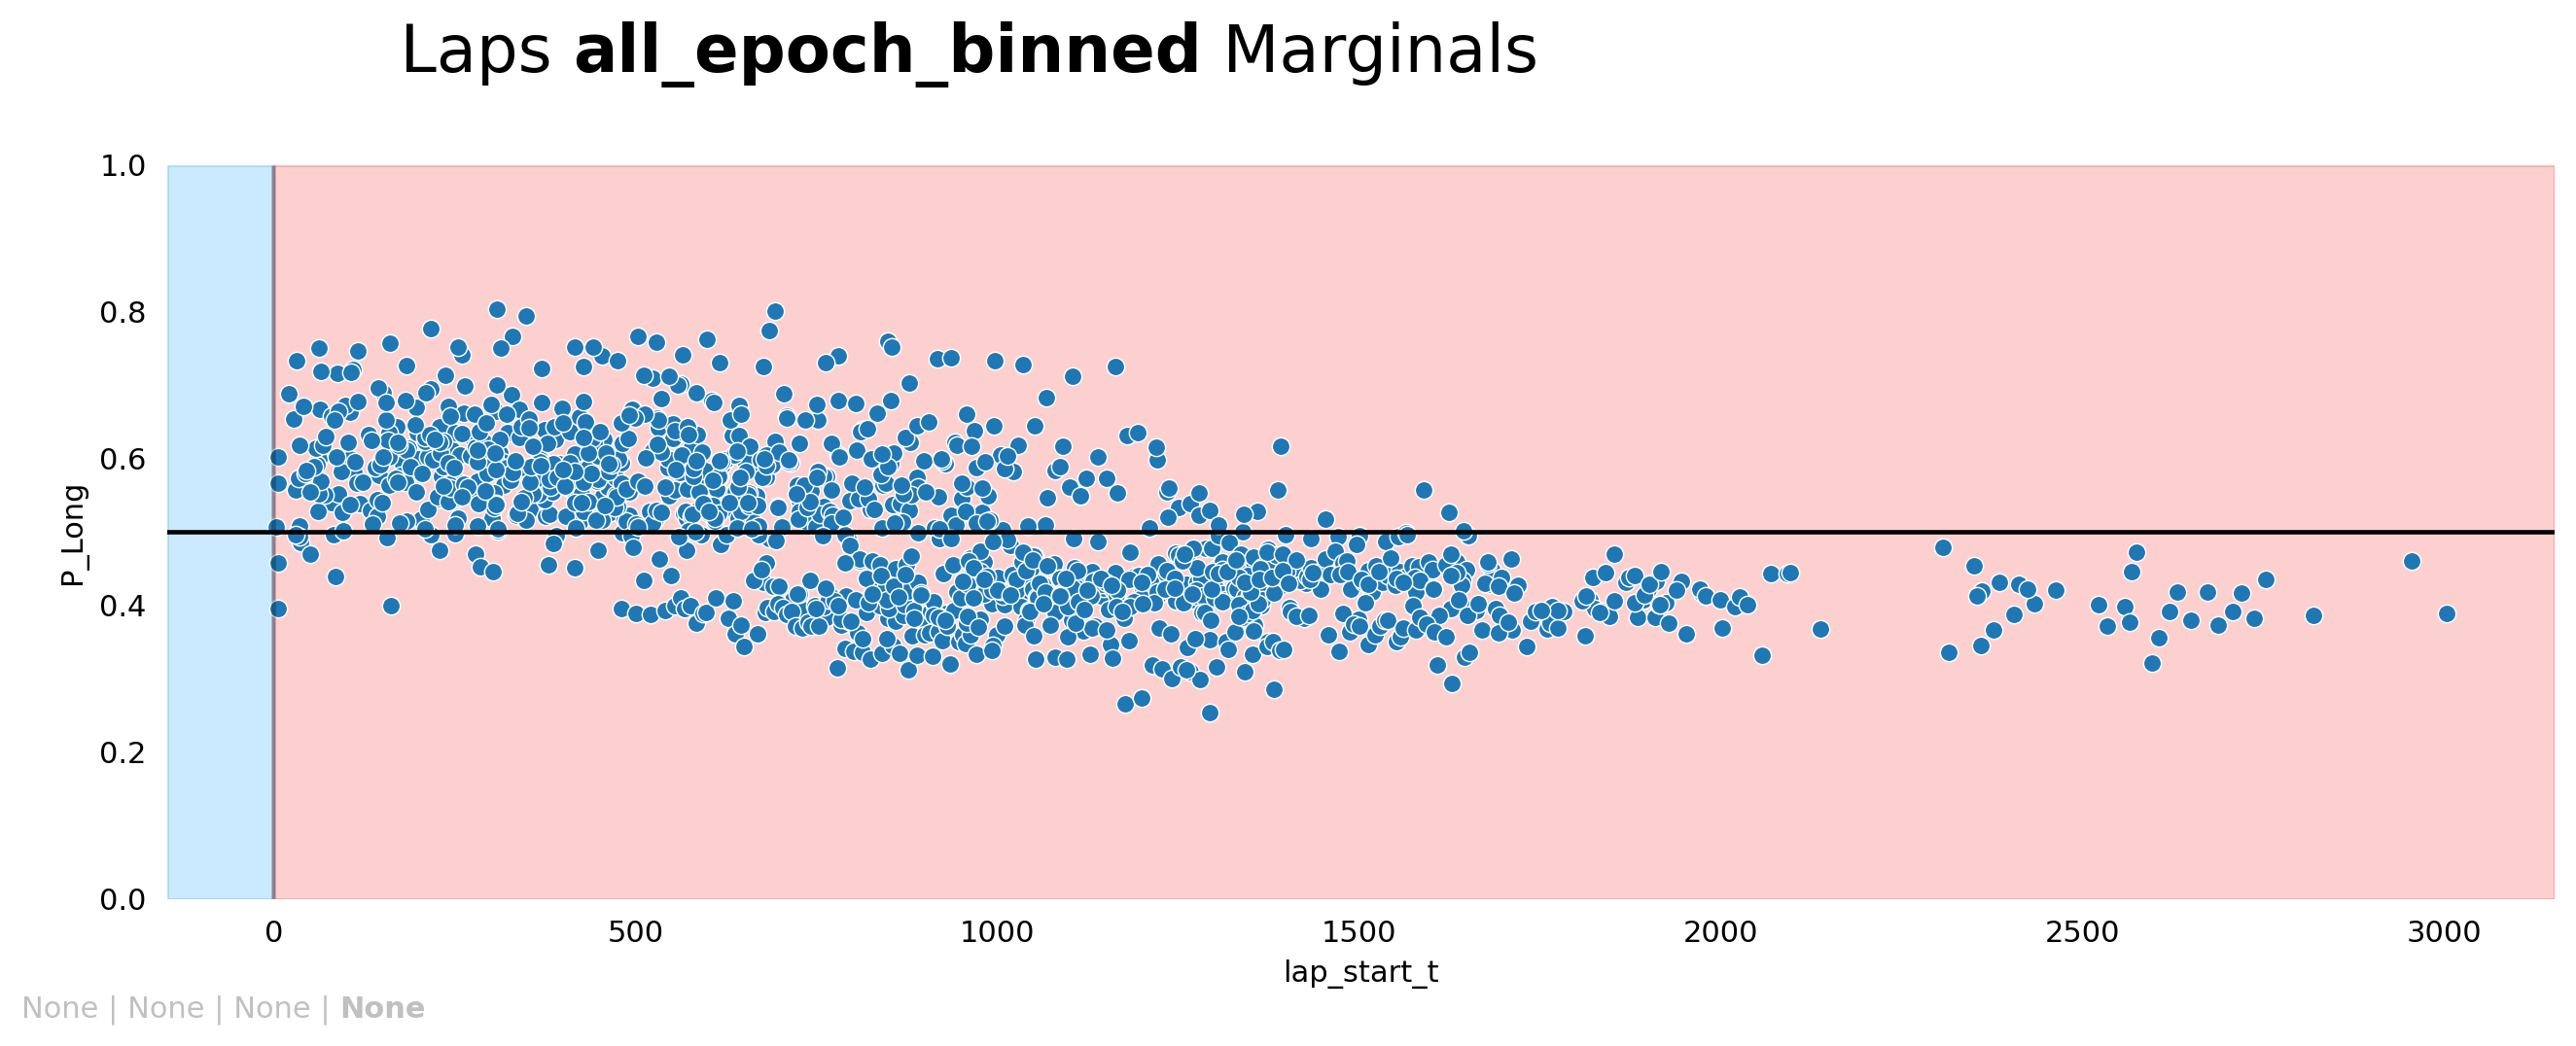

In [16]:
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.DirectionalPlacefieldGlobalComputationFunctions import plot_all_epoch_bins_marginal_predictions
from attrs import define, field, Factory
from neuropy.utils.result_context import IdentifyingContext

@define(slots=False)
class TwoCSV:
	""" simple class wrapper to emulate the object that holds the other dfs """
	laps_all_epoch_bins_marginals_df = field()
	ripple_all_epoch_bins_marginals_df = field()

save_figure = True
def _perform_write_to_file_callback(final_context, fig):
	print(f'final_context: {final_context}')
	# if save_figure:
	# 	fig.save_fig(
	# 	# return owning_pipeline_reference.output_figure(final_context, fig)
	# else:
	# 	pass # do nothing, don't save
	
# all_sessions_laps_time_bin_df

collector = plot_all_epoch_bins_marginal_predictions(TwoCSV(laps_all_epoch_bins_marginals_df=all_sessions_laps_df, ripple_all_epoch_bins_marginals_df=all_sessions_ripple_df), t_start=None, t_split=0.0, t_end=None,
													active_context=IdentifyingContext(), perform_write_to_file_callback=_perform_write_to_file_callback)
collector


result = tuple(collector.figures)
result[0]

In [17]:
result[0].show()

/tmp/ipykernel_206068/3418256831.py:1: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown



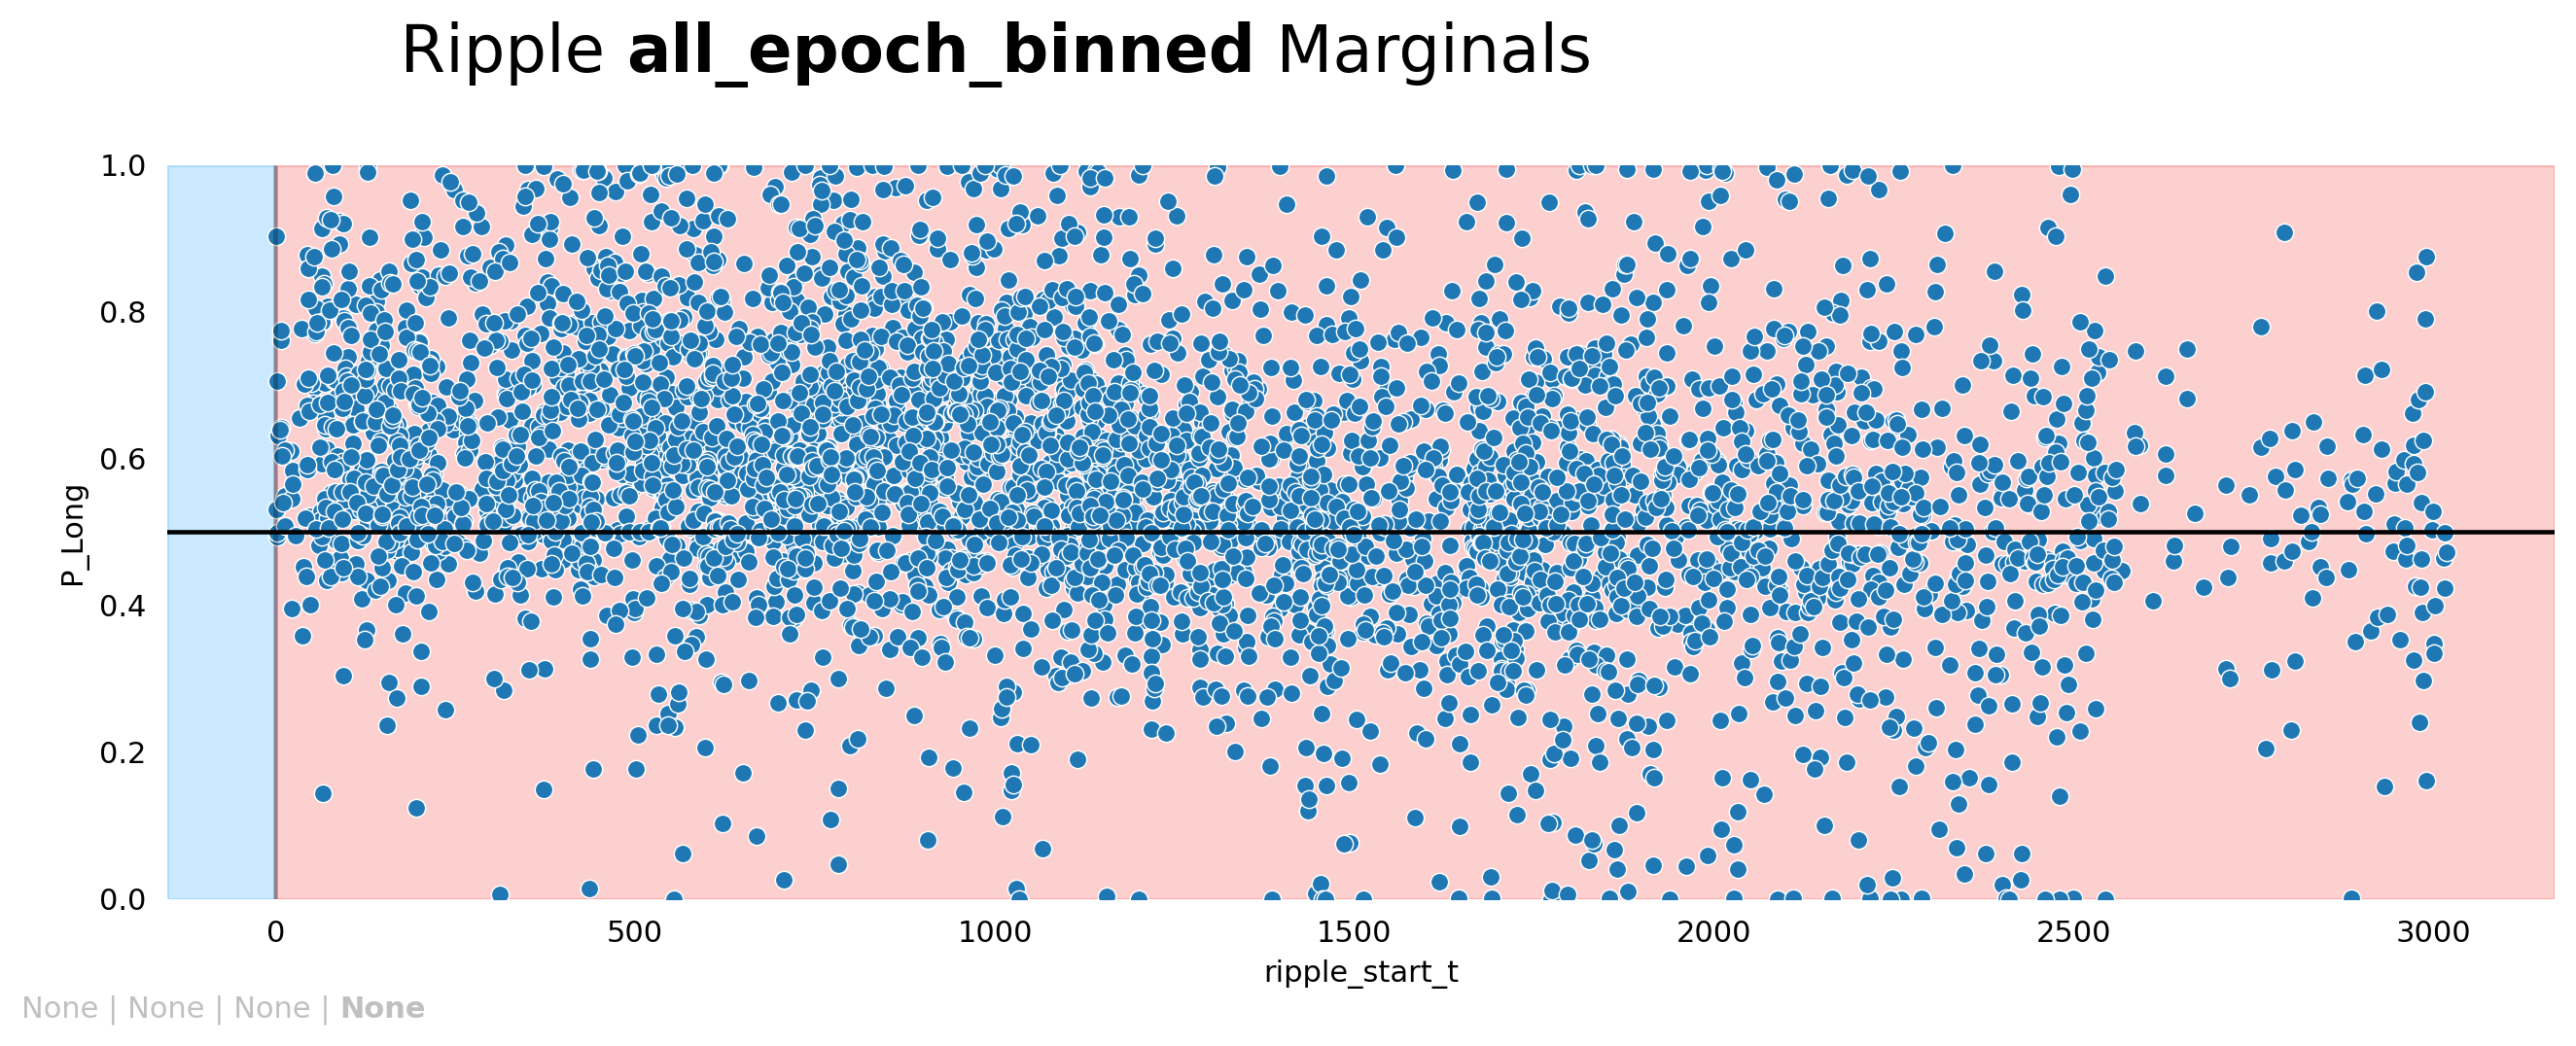

In [18]:
result[1]

In [ ]:
all_sessions_laps_df, all_sessions_ripple_df